In [1]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"viktoriabenkova","key":"0e4fa7fb2884edd855c8804b44964e12"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!rm -rf sample_data

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

# Data preparation

In this section we will download the dataset from kaggle, and prepare it for model.

Following 2 segments takes a lot of time to download and unzip due to big amount of data.

In [4]:
!kaggle competitions download -c landmark-recognition-2021

100% 97.7G/97.7G [09:37<00:00, 234MB/s]
100% 97.7G/97.7G [09:37<00:00, 182MB/s]


In [5]:
file_name = "landmark-recognition-2021.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done!")

Done!


## Load data and analyze data

In [3]:
train_df = pd.read_csv("train.csv")
train_df.head()

id  landmark_id
0  17660ef415d37059            1
1  92b6290d571448f6            1
2  cd41bf948edc0340            1
3  fb09f1e98c6d2f70            1
4  25c9dfc7ea69838d            7

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.1+ MB


In [8]:
landmark_unique = len(train_df['landmark_id'].unique())
print(landmark_unique)

81313


We have 81 313 unique landmarks.

In [4]:
TRAIN_DIR = f'./train'
TEST_DIR = f'./test'

### Visualization of data classes and their counts

In [11]:
print(train_df['landmark_id'].value_counts())

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
84677        2
36989        2
133688       2
17316        2
111405       2
Name: landmark_id, Length: 81313, dtype: int64


In [13]:
freq_df=train_df.groupby('landmark_id').count()
freq_df['frequency']=freq_df['id']
landmark_df=freq_df.drop('id',axis=1)
sorted_df=freq_df.sort_values(by='frequency',ascending=False).reset_index()

From the most frequent...

In [14]:
head_df=sorted_df.head(50)
head_df['landmark_id'] =  head_df.landmark_id.apply(lambda x: f'landmark_{x}')

fig = px.bar(head_df, y="frequency", x="landmark_id",color='landmark_id', orientation='v',
             hover_data=["landmark_id", "frequency"])
fig.show()

<ipython-input-14-1797049fac82>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



...to classes with only few examples.

In [15]:
head_df=sorted_df.tail(50)
head_df['landmark_id'] =  head_df.landmark_id.apply(lambda x: f'landmark_{x}')

fig = px.bar(head_df, y="frequency", x="landmark_id",color='landmark_id', orientation='v',
             hover_data=["landmark_id", "frequency"])
fig.show()

<ipython-input-15-d6b26fb5d473>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Add path to image in dataframe

In [5]:
train_df['path'] = (train_df['id'].apply(lambda r: os.path.join
                            (TRAIN_DIR, r[0], r[1], r[2], r + '.jpg')))

In [11]:
train_df.head()

id  landmark_id                                path
0  17660ef415d37059            1  ./train/1/7/6/17660ef415d37059.jpg
1  92b6290d571448f6            1  ./train/9/2/b/92b6290d571448f6.jpg
2  cd41bf948edc0340            1  ./train/c/d/4/cd41bf948edc0340.jpg
3  fb09f1e98c6d2f70            1  ./train/f/b/0/fb09f1e98c6d2f70.jpg
4  25c9dfc7ea69838d            7  ./train/2/5/c/25c9dfc7ea69838d.jpg

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
 2   path         1580470 non-null  object
dtypes: int64(1), object(2)
memory usage: 36.2+ MB


### Image load and display

In [6]:
IMG_SIZE = 128 

def img_load(img_path): 
    img = plt.imread(img_path)
    img = img/255.
    img_redim = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img_redim

In [7]:
def plot_images(landmark_id=12):
    landmark = train_df[train_df['landmark_id']==landmark_id].head(25)
    imgs = [img_load(x) for x in landmark['path']]
    _, axs = plt.subplots(5,5, figsize=(12, 12))
    axs = axs.flatten()
    for i, (img, ax) in enumerate(zip(imgs, axs)):
        ax.title.set_text(str(landmark['id'].iloc[i]))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

Images of one class.

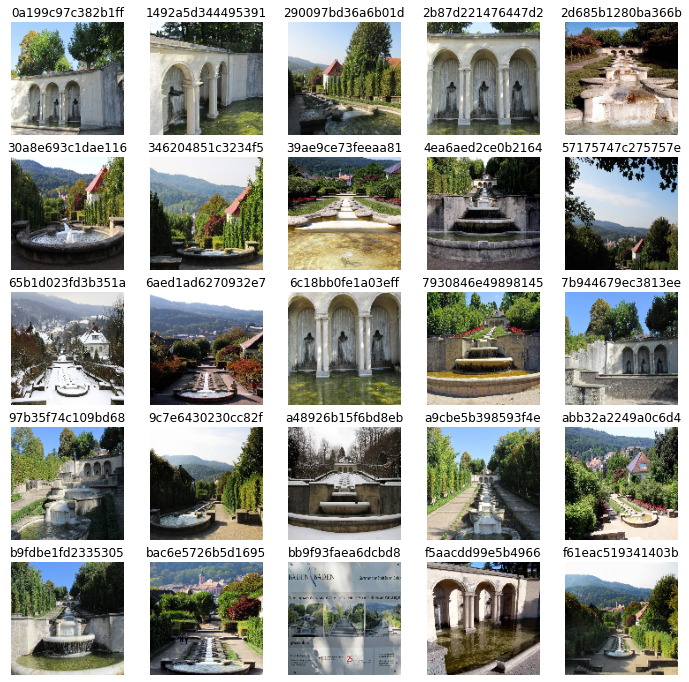

In [8]:
plot_images()

# Prepare smaller dataset (50 labels => 20 labels)

We wanted at least 50 labels but we ran out of RAM, that''s why 20.

In [70]:
print(train_df['landmark_id'].value_counts().head(50))

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
177870    1088
194914    1073
149980     971
139894     966
1924       944
176528     920
9070       900
46705      888
168098     888
20120      888
161902     861
36748      839
120734     820
176018     820
10419      776
45428      757
14915      754
41648      742
165596     734
47378      731
187779     730
38482      704
40088      679
25093      663
162833     662
173511     656
189907     621
190822     614
76303      604
191292     600
109169     597
51856      576
192931     572
41808      570
107164     542
189811     540
101399     538
64792      531
80177      527
27190      520
152708     514
143710     508
31531      505
27         504
113838     503
Name: landmark_id, dtype: int64


In [9]:
subset_df = train_df['landmark_id'].value_counts()[0:20].index
subset_df = train_df.loc[train_df['landmark_id'].isin(subset_df)].copy()

In [10]:
len(subset_df)

26779

In [41]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45077 entries, 119 to 1519189
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           45077 non-null  object
 1   landmark_id  45077 non-null  int64 
 2   path         45077 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


### Encode data

In [11]:
encoder = LabelEncoder()
subset_df['label'] = encoder.fit_transform(subset_df['landmark_id'])
subset_df.head(10)

id  landmark_id                                path  \
14178  00061e23ce736fa9         1924  ./train/0/0/0/00061e23ce736fa9.jpg   
14179  0060992db5cc819f         1924  ./train/0/0/6/0060992db5cc819f.jpg   
14180  008315aa634e14b9         1924  ./train/0/0/8/008315aa634e14b9.jpg   
14181  008e6817cf364cb6         1924  ./train/0/0/8/008e6817cf364cb6.jpg   
14182  00bad7a508ee6666         1924  ./train/0/0/b/00bad7a508ee6666.jpg   
14183  012d1e3ba1a8281f         1924  ./train/0/1/2/012d1e3ba1a8281f.jpg   
14184  0178c81126de7405         1924  ./train/0/1/7/0178c81126de7405.jpg   
14185  01d202a5649f95b4         1924  ./train/0/1/d/01d202a5649f95b4.jpg   
14186  01e828d2555f17a4         1924  ./train/0/1/e/01e828d2555f17a4.jpg   
14187  022cf249792faa2e         1924  ./train/0/2/2/022cf249792faa2e.jpg   

       label  
14178      0  
14179      0  
14180      0  
14181      0  
14182      0  
14183      0  
14184      0  
14185      0  
14186      0  
14187      0

In [12]:
print(len(subset_df['label'].unique()))

20


### Train, val and test data

In [13]:
y_prepared = []
X_prepared = []
subset_df.reset_index(inplace=True, drop=True)

# takes a long time
for i in range(subset_df.shape[0]):  
    #print(i)
    X_prepared.append(img_load(subset_df['path'][i])) 
    y_prepared.append(np.array(subset_df['label'][i]))

print("Done")

Done


In [14]:
X_prepared = np.array(X_prepared)
y_prepared = np.array(y_prepared)    

In [15]:
train_X, val_X, train_y, val_y = train_test_split(X_prepared, y_prepared, test_size=0.2,random_state=40, shuffle=True)

In [16]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size = 0.05, random_state=40, shuffle=True)

In [17]:
# to clear the RAM
del X_prepared
del y_prepared

# Create and train model

In [18]:
from keras.applications import ResNet50

In [29]:
resnet = ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet.trainable=True

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=7,
                          verbose=1,
                          restore_best_weights=True
                          )
callbacks = [early_stopping]

In [34]:
model = tf.keras.Sequential()
model.add(resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(20, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 20)                655380    
                                                                 
Total params: 24,243,092
Trainable params: 24,189,972
Non-trainable params: 53,120
_________________________________________________________________


In [37]:
history = model.fit(train_X, train_y, epochs=10, batch_size=128, validation_data = (val_X, val_y), callbacks=callbacks)

Epoch 1/10
159/159 [==============================] - 458s 3s/step - loss: 0.2527 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.2324 - val_sparse_categorical_accuracy: 0.9376
Epoch 2/10
159/159 [==============================] - 447s 3s/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.2076 - val_sparse_categorical_accuracy: 0.9451
Epoch 3/10
159/159 [==============================] - 449s 3s/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.2539 - val_sparse_categorical_accuracy: 0.9423
Epoch 4/10
159/159 [==============================] - 453s 3s/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.2352 - val_sparse_categorical_accuracy: 0.9481
Epoch 5/10
159/159 [==============================] - 462s 3s/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.2664 - val_sparse_categorical_accuracy: 0.9416
Epoch 6/10
159/159 [==============================] - 458s 3s/step - loss: 0.0167 - sparse_cate

In [39]:
print('Evaluation:')
test_loss, test_acc  = model.evaluate(train_X, train_y)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

test_loss, test_acc = model.evaluate(val_X,  val_y, verbose=2)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

Evaluation:
636/636 [==============================] - 128s 202ms/step - loss: 0.0032 - sparse_categorical_accuracy: 0.9993
Test loss:  0.0032082078978419304
Test accuracy:  0.9992629289627075
168/168 - 33s - loss: 0.2076 - sparse_categorical_accuracy: 0.9451 - 33s/epoch - 195ms/step
Test loss:  0.20756998658180237
Test accuracy:  0.9451082944869995


In [40]:
del train_df

In [35]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


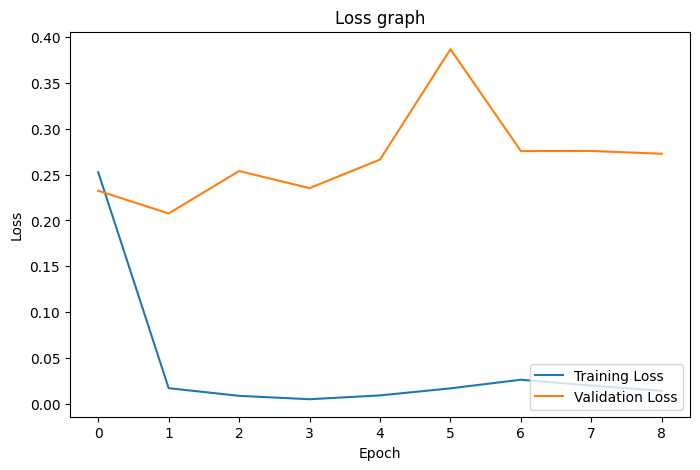

In [78]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss graph')
plt.legend(loc='lower right')

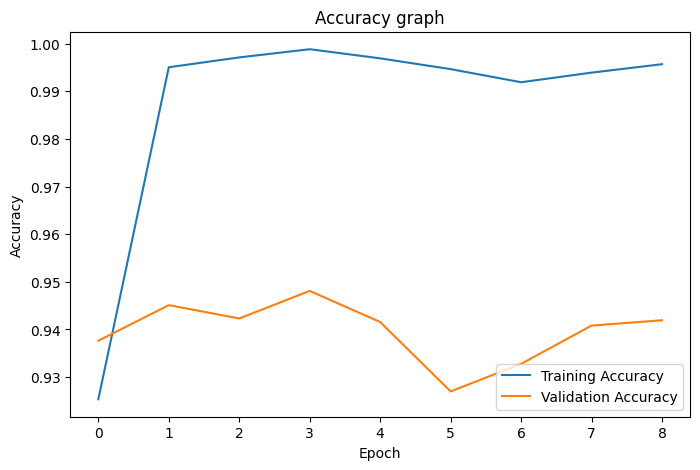

In [79]:
plt.figure(figsize=(8,5))
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy',)
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy graph')
plt.legend(loc='lower right')

### Try with ImageDataGenerator (just trying)

In [29]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

datagen.fit(train_X)

In [30]:
history = model.fit(datagen.flow(train_X, train_y, batch_size=32), epochs=5, validation_data = (val_X, val_y))

Epoch 1/5
95/95 [==============================] - 99s 1s/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9911 - val_loss: 3.3134 - val_sparse_categorical_accuracy: 0.5777
Epoch 2/5
95/95 [==============================] - 96s 1s/step - loss: 0.0108 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.5444 - val_sparse_categorical_accuracy: 0.4198
Epoch 3/5
95/95 [==============================] - 91s 958ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9937 - val_loss: 4.8348 - val_sparse_categorical_accuracy: 0.4236
Epoch 4/5
95/95 [==============================] - 94s 993ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9937 - val_loss: 4.7616 - val_sparse_categorical_accuracy: 0.5777
Epoch 5/5
95/95 [==============================] - 88s 928ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.7945 - val_sparse_categorical_accuracy: 0.6767


In [31]:
print('Evaluation:')
test_loss, test_acc  = model.evaluate(train_X, train_y)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

test_loss, test_acc = model.evaluate(val_X,  val_y, verbose=2)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

Evaluation:
95/95 [==============================] - 18s 189ms/step - loss: 0.8283 - sparse_categorical_accuracy: 0.6605
Test loss:  0.828315258026123
Test accuracy:  0.6605080962181091
25/25 - 4s - loss: 0.7945 - sparse_categorical_accuracy: 0.6767 - 4s/epoch - 180ms/step
Test loss:  0.7945206165313721
Test accuracy:  0.6766917109489441


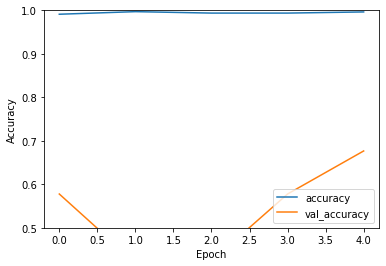

In [32]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Predict

In [55]:
prediction = model.predict(test_X, verbose=1) 

34/34 [==============================] - 7s 199ms/step


In [56]:
pred_y = []

for i in range(len(prediction)):
    pred_y.append(np.argmax(prediction[i]))   

In [61]:
test_loss, test_acc = model.evaluate(test_X, test_y)
print('Final data test loss: ', test_loss)
print('Final data test accuracy: ', test_acc)

34/34 [==============================] - 7s 209ms/step - loss: 0.2023 - sparse_categorical_accuracy: 0.9496
Final data test loss:  0.20229430496692657
Final data test accuracy:  0.9496268630027771


In [66]:
pred_y = encoder.inverse_transform(pred_y)
test_y = encoder.inverse_transform(test_y)

Show similar images to predicted results.

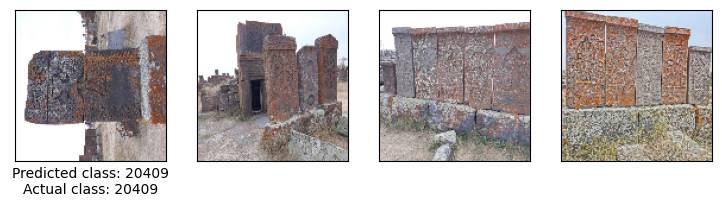

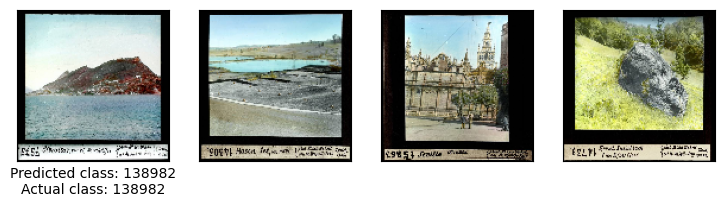

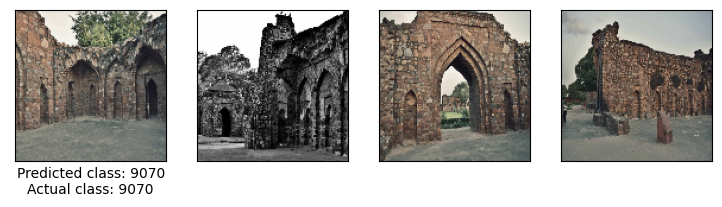

In [76]:
for k in range(5,10,2):
    plt.figure(figsize=(9,6))
    plt.subplot(1, 4, 1)
    img_pred = test_X[k]
    plt.xticks([])
    plt.yticks([])
    str1 = 'Predicted class: ' + str(pred_y[k])
    str3 = 'Actual class: ' + str(test_y[k])
    plt.xlabel(str1 + '\n' + str3)                  
    plt.imshow(img_pred)
    
    i=0
    img_class_df = subset_df[subset_df['landmark_id']==pred_y[k]]  
                                                              
    
    for i in range(len(img_class_df)):
        if i < (3): 
            img_class_path = img_class_df.iloc[i,2] 
            img_class = img_load(img_class_path)
            plt.subplot(1, 4, i+2)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(str())
            plt.imshow(img_class)
        else:
            break;